In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import read_image
from tqdm import tqdm

import pandas as pd
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu")

device

'cuda:0'

In [15]:
cap = cv2.VideoCapture('../data/test_set/test_set/test_23.jpg')
cap2 = cv2.imread("../data/test_set/test_set/test_23.jpg")
fgbg = cv2.createBackgroundSubtractorMOG2()
ret, frame = cap.read()
 
fgmask = fgbg.apply(frame)
fgmask = np.repeat(fgmask[:, :, np.newaxis], 3, axis=2)

img = cap2 - fgmask

cv2.imshow('fgmask', fgmask)
cv2.imshow('frame',frame )
cv2.imshow("Image", img)

k = cv2.waitKey(0)

cap.release()
cv2.destroyAllWindows()

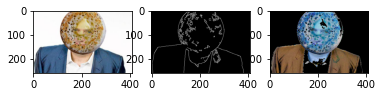

In [89]:
# Read the image
img = cv2.imread("../data/test_set/test_set/test_56.jpg")

# Apply thresholds for the bound selection
threshold1,threshold2 = 50, 700
grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
image = cv2.Canny(img, threshold1, threshold2)

# Convert images to correct sizes
image_new = np.repeat(image[:, :, np.newaxis], 3, axis=2)
grey_new = np.repeat(grey[:, :, np.newaxis], 3, axis=2)

# Applying grey scale and applying the bounds --> These need to be optimized.
new_image = img * image_new + (1 - grey_new)
new_image = img * ((new_image > 50) * (new_image < 220))

#selecting the color range to be extracted
fig = plt.figure(figsize=(6, 2))
axarr = fig.subplots(1, 3)

axarr[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axarr[1].imshow(image, cmap='gray')
axarr[2].imshow(new_image)

plt.show()

In [7]:
class food_train(Dataset):

    def __init__(self, labels_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(labels_file, names=['img_name', 'label'], header=1)[:25000]
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
            
        if self.target_transform:
            image = self.target_transform(label)
        
        return image, label

In [8]:
class food_val(Dataset):

    def __init__(self, labels_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(labels_file, names=['img_name', 'label'], header=1)[25000:]
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
            
        if self.target_transform:
            image = self.target_transform(label)
        
        return image, label

In [9]:
class food_test(Dataset):

    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        file_name = os.listdir(self.img_dir)[idx]
        img_path = os.path.join(self.img_dir, file_name)
        image = read_image(img_path)
       
        if self.transform:
            image = self.transform(image)
        
        return file_name, image

In [ ]:
def remove_background(image):
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    _, thresh = cv2.threshold(gray_img, 127, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    img_contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[-2]
    img_contours = sorted(img_contours, key=cv2.contourArea)

    for i in img_contours:
        if cv2.contourArea(i) > 100:
            break
            
    mask = np.zeros(img.shape[:2], np.uint8)
    cv2.drawContours(mask, [i],-1, 255, -1)
    new_img = cv2.bitwise_and(img, img, mask=mask)
    
    return new_img

In [22]:
img_dir = "../data/train_set/train_set"
labels = "../data/train_labels.csv"

transform = transforms.Compose(
                    [transforms.Resize((256,256)),
                     transforms.ConvertImageDtype(torch.float),
                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])])


train_set = food_train(labels, img_dir, transform = transform)  
trainloader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=0)

val_set = food_val(labels, img_dir, transform = transform)
valloader = DataLoader(val_set, batch_size=32, shuffle=True, num_workers=0)


len(train_set), len(val_set), train_set

(25000, 5611, <__main__.food_train at 0x2a0ec338888>)

In [11]:
test_set = food_test("../data/test_set/test_set", transform = transform)
testloader = DataLoader(test_set, batch_size = 32, shuffle=True, num_workers=0)

len(test_set)

7653

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[[ 0.6221,  0.5878,  0.4851,  ...,  1.6495,  1.6495,  1.6495],
          [ 0.5878,  0.5364,  0.4337,  ...,  1.6495,  1.6495,  1.6495],
          [ 0.5193,  0.4679,  0.3652,  ...,  1.6495,  1.6495,  1.6495],
          ...,
          [ 1.0673,  0.9988,  0.9474,  ...,  1.6324,  1.5982,  1.5468],
          [ 1.1872,  1.1015,  1.0159,  ...,  1.6838,  1.6324,  1.5810],
          [ 1.2557,  1.1700,  1.0844,  ...,  1.7352,  1.6838,  1.6324]],

         [[ 0.5553,  0.4678,  0.3277,  ...,  1.0105,  1.0105,  1.0105],
          [ 0.4853,  0.3978,  0.2752,  ...,  1.0105,  1.0105,  1.0105],
          [ 0.3803,  0.3102,  0.1702,  ...,  1.0105,  1.0105,  1.0105],
          ...,
          [ 1.0105,  0.9055,  0.8004,  ...,  0.7829,  0.7479,  0.6954],
          [ 1.1506,  1.0455,  0.9055,  ...,  0.8004,  0.7479,  0.6954],
          [ 1.2556,  1.1331,  0.9930,  ...,  0.8004,  0.7479,  0.6954]],

         [[ 0.3393,  0.2348,  0.0605,  ..., -1.7870, -1.7870, -1.7870],
          [ 0.2522,  0.1651,  

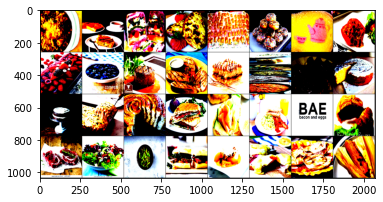

tensor(76) tensor(63) tensor(65) tensor(42) tensor(68) tensor(43) tensor(24) tensor(11)


In [24]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()


batch_size = 8

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(batch_size)))

In [13]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3080'

In [14]:
resnet = models.resnet18(pretrained=True)
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

In [16]:
def train_loop(dataloader, model, criterion, optimizer):
    size = len(dataloader.dataset)
    
    model.train()
    for epoch in range(15):
        for batch, (image, label) in enumerate(dataloader):
            # Compute prediction and loss
            image, label = image.to(device), label.to(device)
            pred = model(image)
            loss = criterion(pred, label)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch % 200 == 0:
                loss, current = loss.item(), batch * len(image)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}] epoch: {epoch}")
                
        print(f"Epoch: {epoch}")
        test_loop(valloader, resnet, criterion)


def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for image, label in dataloader:
            image, label = image.to(device), label.to(device)
            pred = model(image)
            test_loss += criterion(pred, label).item()
            correct += (pred.argmax(1) == label).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [17]:
train_loop(trainloader, resnet, criterion, optimizer)

loss: 9.329361  [    0/25000] epoch: 0
loss: 3.613827  [ 6400/25000] epoch: 0
loss: 2.510304  [12800/25000] epoch: 0
loss: 2.417517  [19200/25000] epoch: 0
Epoch: 0
Test Error: 
 Accuracy: 46.3%, Avg loss: 2.181032 

loss: 2.007898  [    0/25000] epoch: 1
loss: 1.333537  [ 6400/25000] epoch: 1
loss: 1.445452  [12800/25000] epoch: 1
loss: 1.616699  [19200/25000] epoch: 1
Epoch: 1
Test Error: 
 Accuracy: 52.2%, Avg loss: 1.897746 

loss: 1.443938  [    0/25000] epoch: 2
loss: 1.499022  [ 6400/25000] epoch: 2
loss: 1.371153  [12800/25000] epoch: 2
loss: 0.518544  [19200/25000] epoch: 2
Epoch: 2
Test Error: 
 Accuracy: 54.1%, Avg loss: 1.839869 

loss: 0.803526  [    0/25000] epoch: 3
loss: 0.861349  [ 6400/25000] epoch: 3
loss: 0.616799  [12800/25000] epoch: 3
loss: 1.596376  [19200/25000] epoch: 3
Epoch: 3
Test Error: 
 Accuracy: 54.1%, Avg loss: 1.851177 

loss: 0.543614  [    0/25000] epoch: 4
loss: 0.349235  [ 6400/25000] epoch: 4
loss: 0.602058  [12800/25000] epoch: 4
loss: 0.600816 

KeyboardInterrupt: 